# Perturbing initial conditions in the basin

### Classes and modules

In [1]:
#Lets have matplotlib "inline"
%matplotlib inline

import os
import sys

#Import packages we need
import numpy as np
import datetime
from IPython.display import display
import copy

#For plotting
import matplotlib
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

plt.rcParams["lines.color"] = "w"
plt.rcParams["text.color"] = "w"
plt.rcParams["axes.labelcolor"] = "w"
plt.rcParams["xtick.color"] = "w"
plt.rcParams["ytick.color"] = "w"

plt.rcParams["image.origin"] = "lower"

import pycuda.driver as cuda

GPU Ocean-modules:

In [2]:
from gpuocean.utils import IPythonMagic, Common
from gpuocean.SWEsimulators import CDKLM16, ModelErrorKL

In [3]:
%cuda_context_handler gpu_ctx

In [4]:
gpu_stream = cuda.Stream()

Utils

In [5]:
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '../')))
from utils.BasinInit import *

In [6]:
def imshow3(etahuhv, negative_vlim=True,  eta_vlim=0.05, huv_vlim=2, cmap="coolwarm", title=None):
    fig, axs = plt.subplots(1,3, figsize=(15,10))
    fig.suptitle(title, y=0.85)

    im = axs[0].imshow(etahuhv[0], vmin=-negative_vlim*eta_vlim, vmax=eta_vlim, cmap=cmap)
    plt.colorbar(im, ax=axs[0], shrink=0.5)
    axs[0].set_title("$\eta$", fontsize=15)

    im = axs[1].imshow(etahuhv[1], vmin=-negative_vlim*huv_vlim, vmax=huv_vlim, cmap=cmap)
    plt.colorbar(im, ax=axs[1], shrink=0.5)
    axs[1].set_title("$hu$", fontsize=15)

    im = axs[2].imshow(etahuhv[2], vmin=-negative_vlim*huv_vlim, vmax=huv_vlim, cmap=cmap)
    plt.colorbar(im, ax=axs[2], shrink=0.5)
    axs[2].set_title("$hv$", fontsize=15)

    return fig, axs

In [7]:
def imshow3var(est_var, eta_vlim=0.00025, huv_lim=1.0):
    return imshow3(est_var, negative_vlim=False, eta_vlim=eta_vlim, huv_vlim=huv_lim, cmap="Reds")

In [8]:
def imshowSim(sim, **kvargs):
    eta, hu, hv = sim.download(interior_domain_only=True)
    return imshow3(np.array([eta, hu, hv]), **kvargs)

### Perturbing initial conditions

In [9]:
sample_args = {
    "g": 9.81,
    "f": 0.0012,
    }

In [10]:
ls = [6, 7, 8, 9, 10]

In [11]:
model_error_args_list = []

for l in ls:
    lvl_grid_args = initGridSpecs(l)
    model_error_args_list.append( {
        "nx": lvl_grid_args["nx"],
        "ny": lvl_grid_args["ny"],
        "dx": lvl_grid_args["dx"],
        "dy": lvl_grid_args["dy"],
        "gpu_ctx": gpu_ctx,
        "gpu_stream": gpu_stream,
        "boundary_conditions": Common.BoundaryConditions(2,2,2,2)
        } )

### Initial conditions

\begin{equation}
\eta(x,y) = a~e^{-b(x^2 + y^2)}
\end{equation}

This gives steady state currents
\begin{equation}
\begin{split}
hv(x,y) &= - \frac{g(\eta(x,y) + H)}{f}2xb e^{-b(x^2 + y^2)} \\
hu(x,y) &= \frac{g(\eta(x,y) + H)}{f}2yb e^{-b(x^2 + y^2)}
\end{split}
\end{equation}

Using a positive bump in the upper part and a negative bump in the lower part of the domain

In [12]:
def make_init_steady_state(args, a=1, b = 2.5e-9):
    dataShape = (args["ny"] + 4, args["nx"] + 4)
    dataShapeH = (args["ny"] + 5, args["nx"] + 5)

    eta0 = np.zeros(dataShape, dtype=np.float32)
    hu0  = np.zeros(dataShape, dtype=np.float32)
    hv0  = np.zeros(dataShape, dtype=np.float32)
    H_const = 60
    Hi = np.ones(dataShapeH, dtype=np.float32)*H_const

    nx = args["nx"]
    ny = args["ny"]
    dx = args["dx"]
    dy = args["dy"]


    def add_bump(x_bump, y_bump, a, b):
        X = np.arange(start=0.5*dx, stop=nx*dx , step=dx) - x_bump
        Y = np.arange(start=0.5*dy, stop=ny*dy , step=dy) - y_bump
        YY, XX = np.meshgrid(X, Y)

        etaBump = a*np.exp(-b*(XX*XX + YY*YY))
        eta0[2:-2, 2:-2] += etaBump

        DetaDX = -a*2*b*XX*np.exp(-b*(XX*XX + YY*YY))
        DetaDY = -a*2*b*YY*np.exp(-b*(XX*XX + YY*YY))

        hu0[2:-2,2:-2] += -(sample_args["g"]*(etaBump + H_const)/sample_args["f"])*DetaDX
        hv0[2:-2,2:-2] += (sample_args["g"]*(etaBump + H_const)/sample_args["f"])*DetaDY


    add_bump(nx*dx/2, ny*dy/2 + ny*dy/6, a, b)
    add_bump(nx*dx/2, ny*dy/2 - ny*dy/6, -a, b)

    return {"eta": eta0, "hu": hu0, "hv": hv0, "Hi": Hi}


In [13]:
def make_sim(me_args, init_fields = None):
    if init_fields is None:
        init_fields = make_init_fields(me_args)

    sim_args = {
        "gpu_ctx" : gpu_ctx,
        "nx" : me_args["nx"],
        "ny" : me_args["ny"],
        "dx" : me_args["dx"],
        "dy" : me_args["dy"],
        "f"  : sample_args["f"],
        "g"  : sample_args["g"],
        "r"  : 0,
        "dt" : 0,
        "boundary_conditions": Common.BoundaryConditions(2,2,2,2),
        "eta0" : init_fields["eta"],
        "hu0"  : init_fields["hu"],
        "hv0"  : init_fields["hv"],
        "H"    : init_fields["Hi"],
    }

    return CDKLM16.CDKLM16(**sim_args)

(<Figure size 1080x720 with 6 Axes>,
 array([<AxesSubplot:title={'center':'$\\eta$'}>,
        <AxesSubplot:title={'center':'$hu$'}>,
        <AxesSubplot:title={'center':'$hv$'}>], dtype=object))

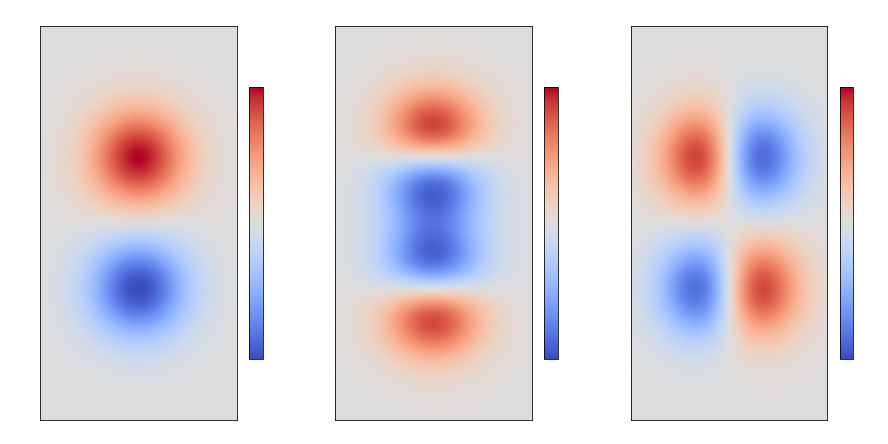

In [14]:
init_fields = make_init_steady_state(model_error_args_list[-1])
sim = make_sim(model_error_args_list[-1], init_fields)
imshowSim(sim, eta_vlim=1, huv_vlim=25)

Same on a coarser level

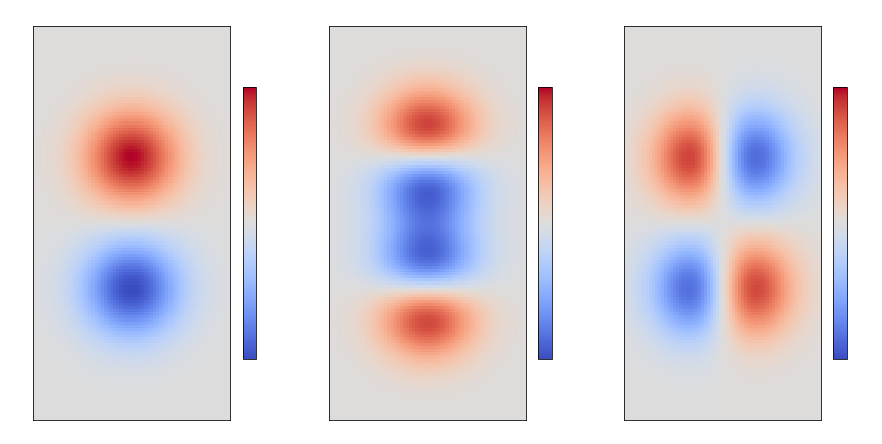

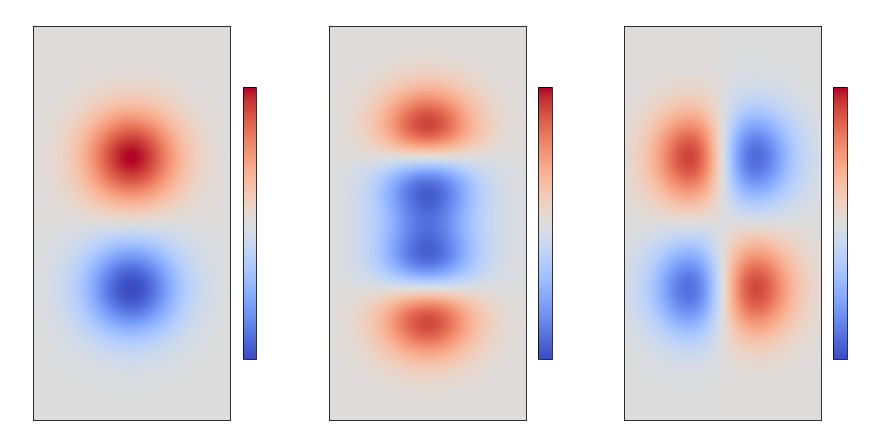

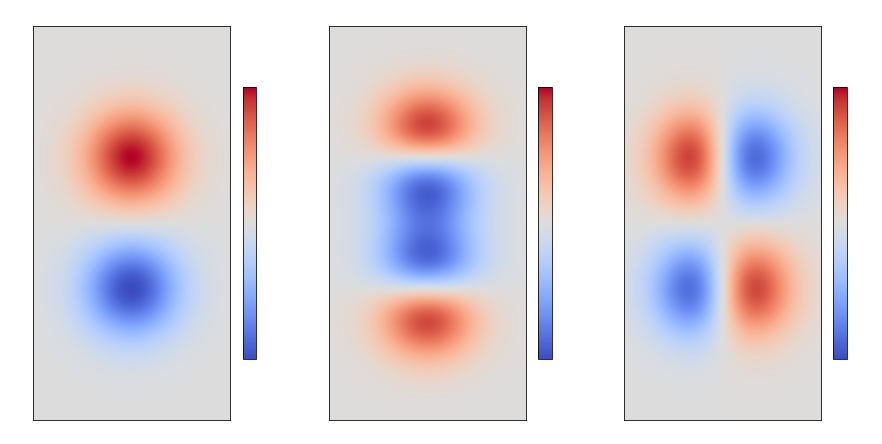

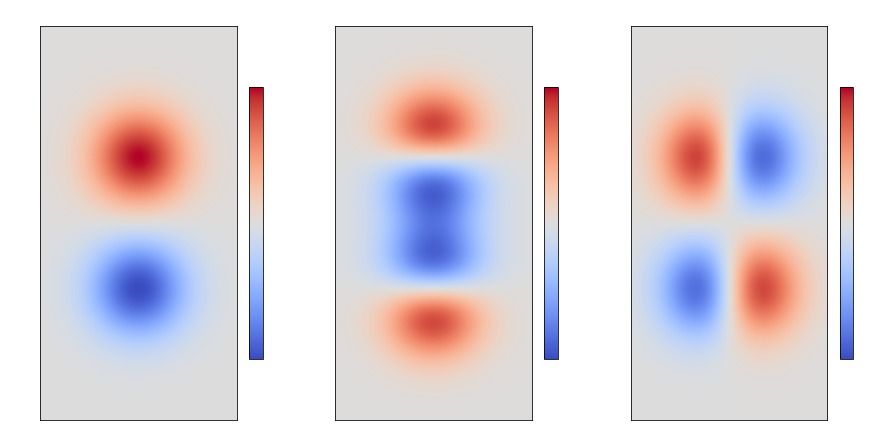

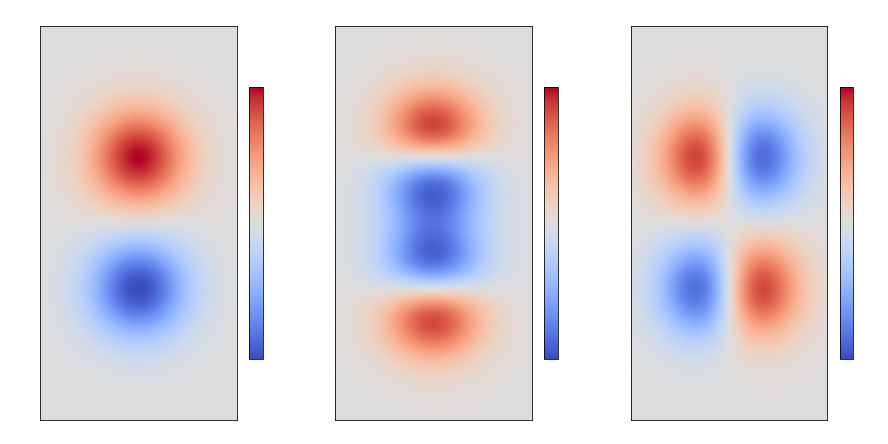

In [15]:
for l_idx in range(len(ls)):
    tmp_init_fields = make_init_steady_state(model_error_args_list[l_idx])
    tmp_sim = make_sim(model_error_args_list[l_idx], tmp_init_fields)
    imshowSim(tmp_sim, eta_vlim=1, huv_vlim=25)

Comparing direct coarse initialisation vs. projected coarse initialisation 

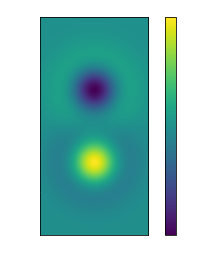

In [16]:
from skimage.measure import block_reduce
plt.imshow(block_reduce(init_fields["eta"][2:-2,2:-2], block_size=(2,2), func=np.mean) - make_init_steady_state(model_error_args_list[-2])["eta"][2:-2,2:-2])
plt.colorbar()

#### Simulation (without model error)

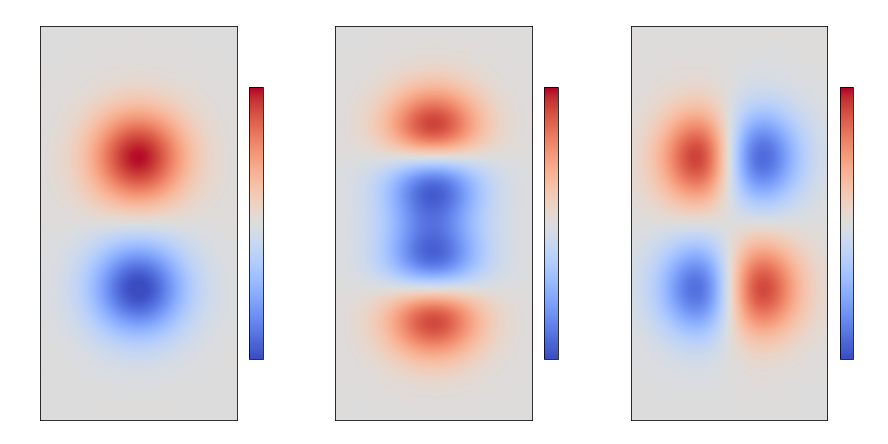

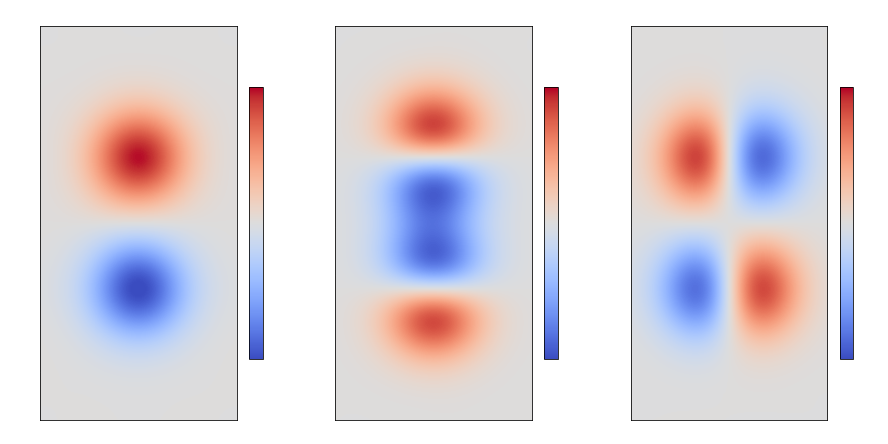

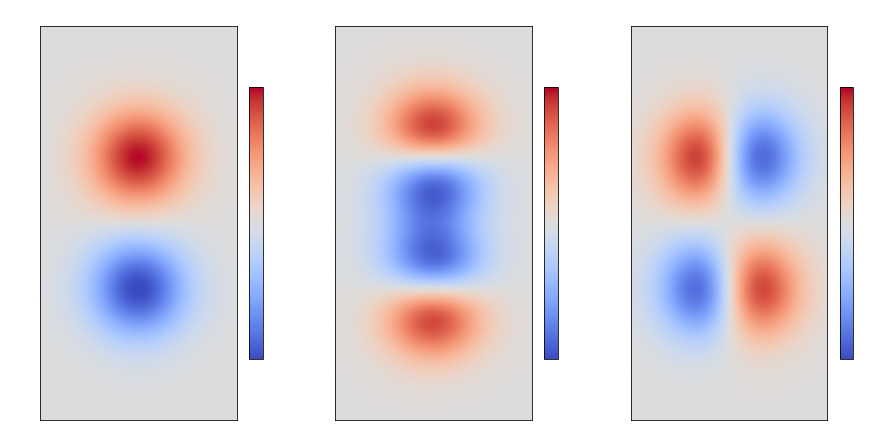

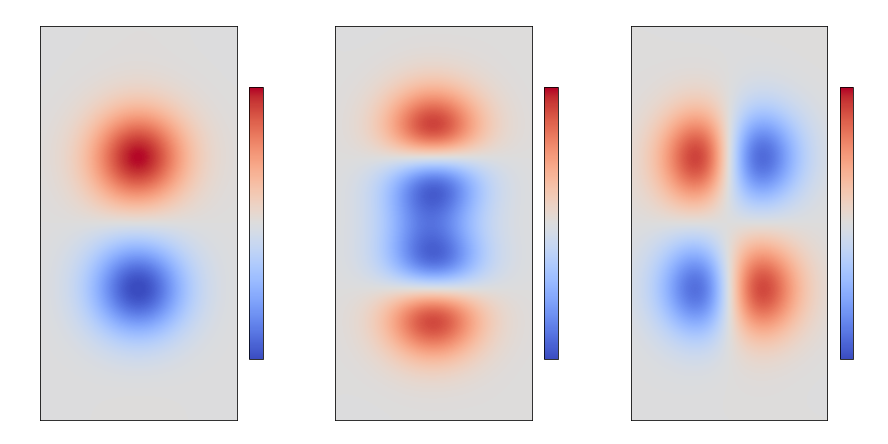

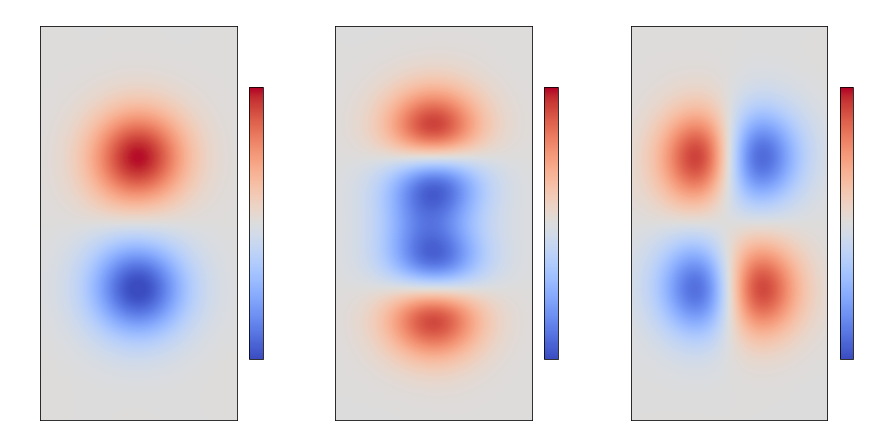

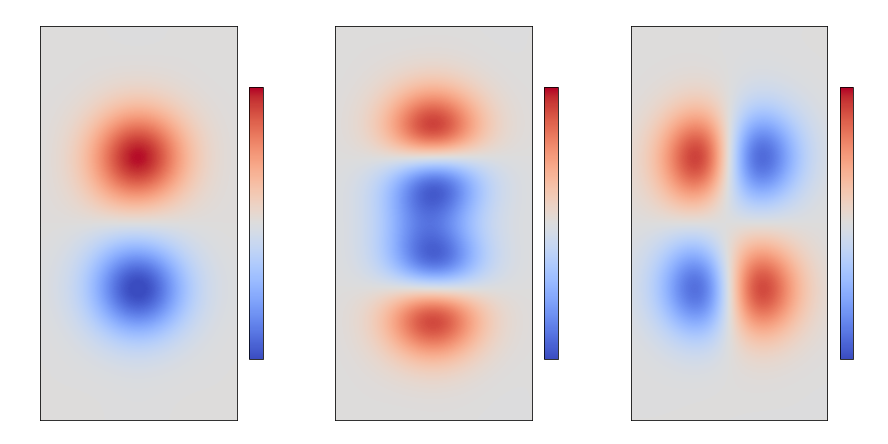

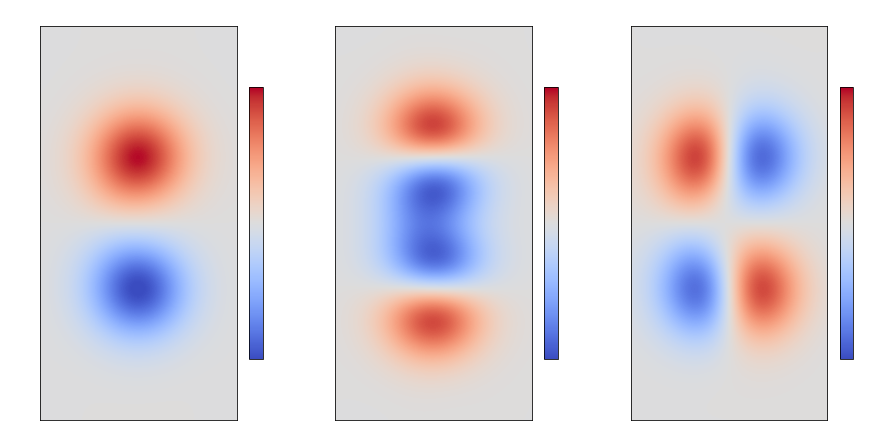

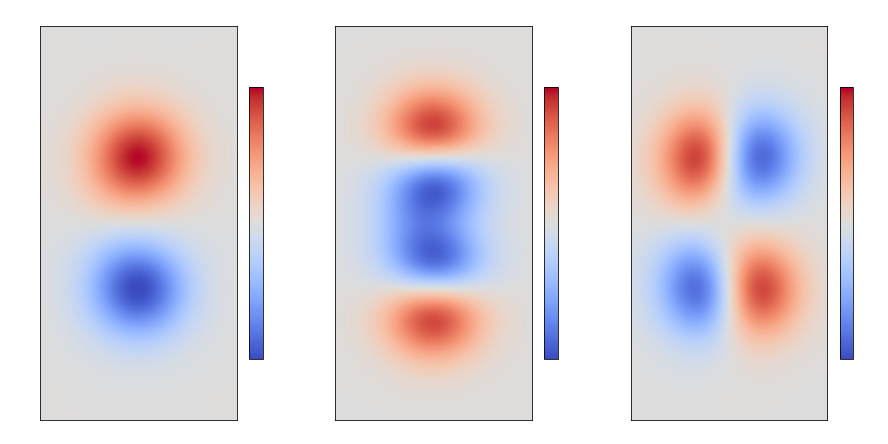

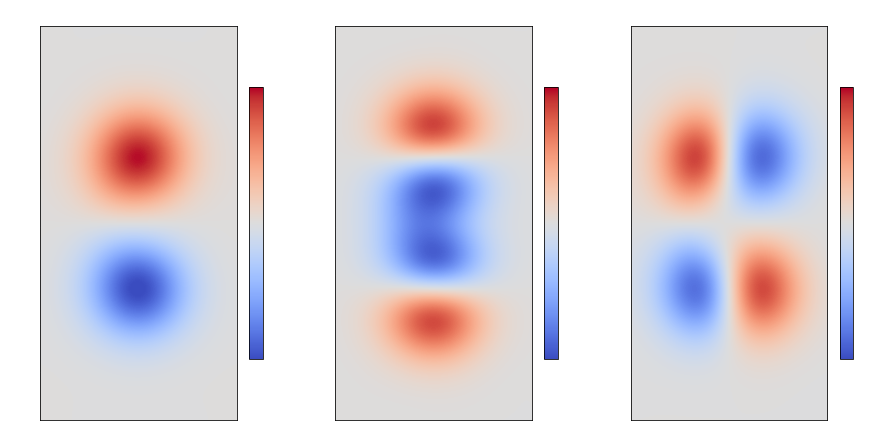

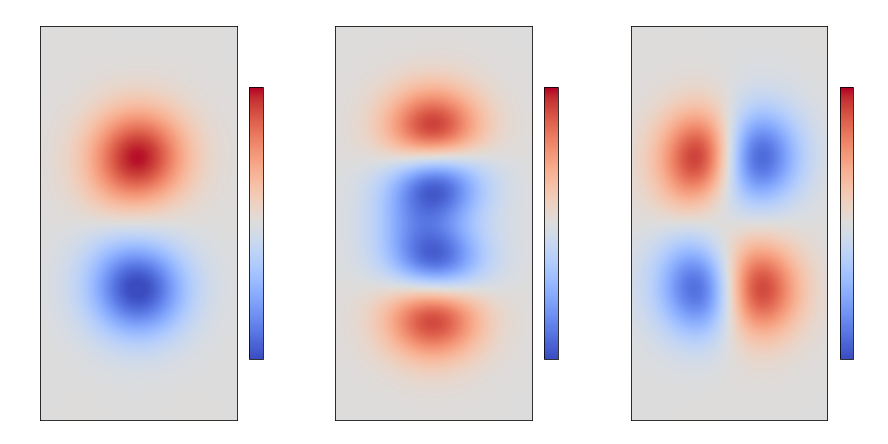

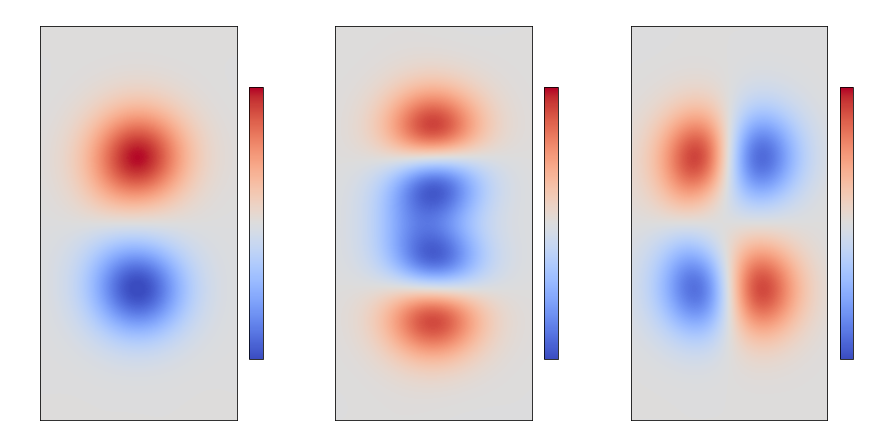

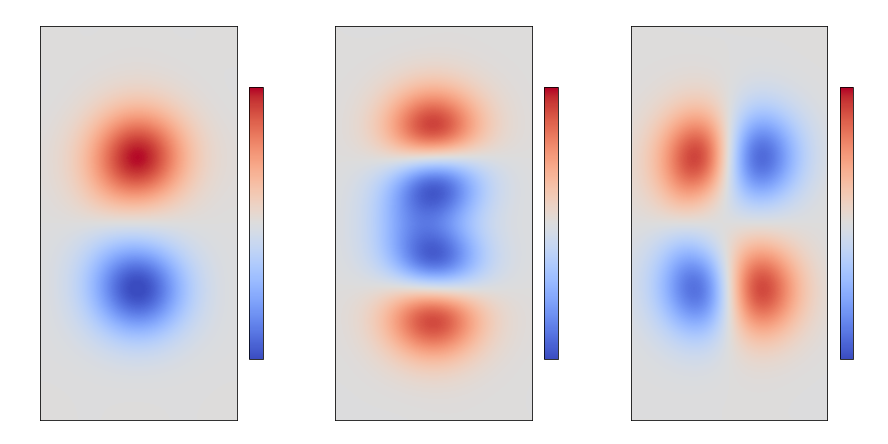

In [17]:
for hour in range(12):
    sim.step(3600)
    imshowSim(sim, eta_vlim=1, huv_vlim=25)

### Simulation (with model error)

In [18]:
sim_model_error_basis_args = {
    "basis_x_start": 1, 
    "basis_x_end": 7,
    "basis_y_start": 2,
    "basis_y_end": 8,

    "kl_decay": 1.25,
    "kl_scaling": 0.0025,
}



In [19]:
# sim = make_sim(model_error_args_list[-1], init_fields)
# sim.setKLModelError(**sim_model_error_basis_args)

# for hour in range(12):
#     print(hour)
#     for minute in range(60):
#         sim.step(60, apply_stochastic_term=False)
#         sim.perturbState()
# imshowSim(sim, eta_vlim=0.5, huv_vlim=15)

In [20]:
sim = make_sim(model_error_args_list[-1], init_fields)
sim.setKLModelError(**sim_model_error_basis_args)

In [21]:
coarse_init_fields = make_init_steady_state(model_error_args_list[-2])
coarse_sim = make_sim(model_error_args_list[-2], coarse_init_fields)
coarse_sim.setKLModelErrorSimilarAs(sim)

In [22]:
sim.model_time_step = 60
sim.dataAssimilationStep(12*3600, otherSim=coarse_sim)

(<Figure size 1080x720 with 6 Axes>,
 array([<AxesSubplot:title={'center':'$\\eta$'}>,
        <AxesSubplot:title={'center':'$hu$'}>,
        <AxesSubplot:title={'center':'$hv$'}>], dtype=object))

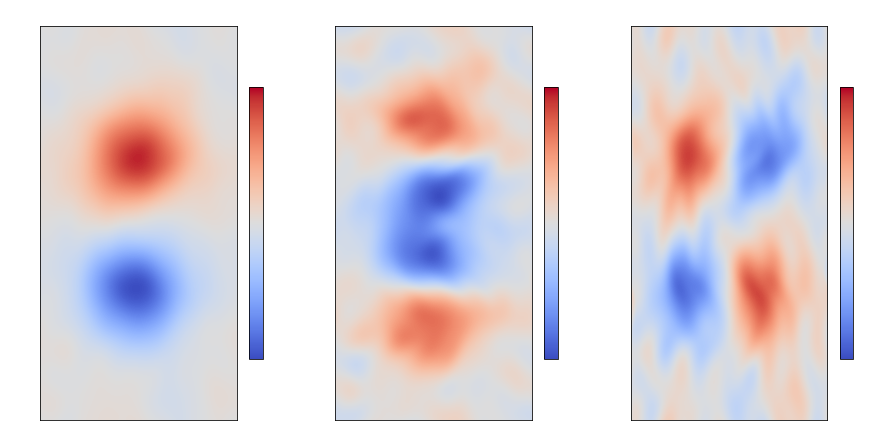

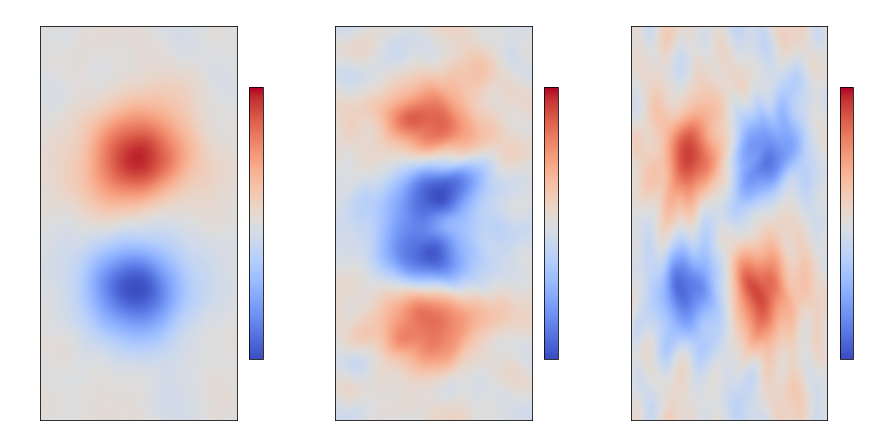

In [23]:
imshowSim(sim, eta_vlim=1, huv_vlim=25)
imshowSim(coarse_sim, eta_vlim=1, huv_vlim=25)

### Coarsest Simulation

(<Figure size 1080x720 with 6 Axes>,
 array([<AxesSubplot:title={'center':'$\\eta$'}>,
        <AxesSubplot:title={'center':'$hu$'}>,
        <AxesSubplot:title={'center':'$hv$'}>], dtype=object))

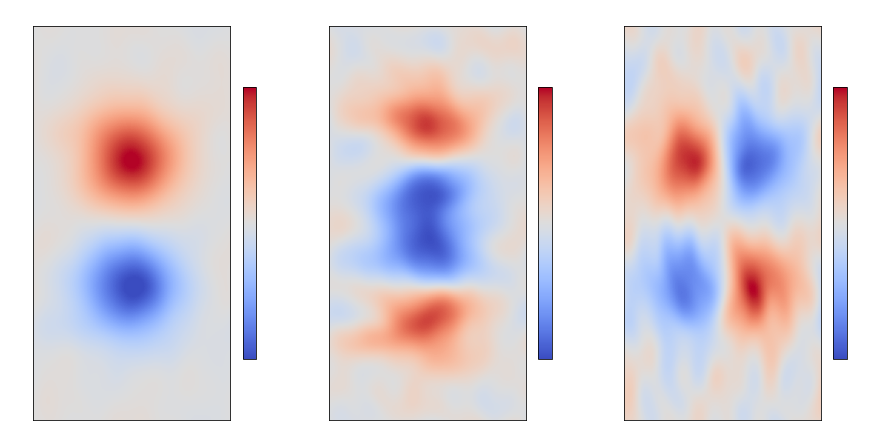

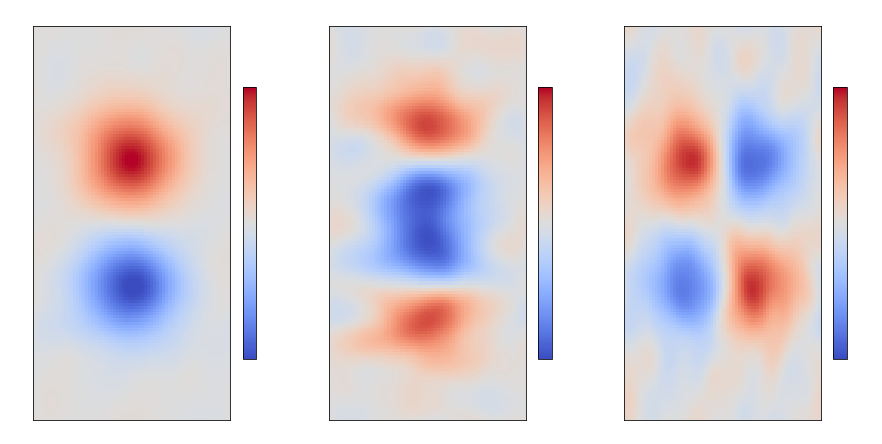

In [24]:
init_fields1 = make_init_steady_state(model_error_args_list[1])
sim1 = make_sim(model_error_args_list[1], init_fields1)

init_fields0 = make_init_steady_state(model_error_args_list[0])
sim0 = make_sim(model_error_args_list[0], init_fields0)

sim1.setKLModelError(**sim_model_error_basis_args)
sim0.setKLModelErrorSimilarAs(sim1)

sim1.model_time_step = 60
sim1.dataAssimilationStep(12*3600, otherSim=sim0)

imshowSim(sim1, eta_vlim=1, huv_vlim=25)
imshowSim(sim0, eta_vlim=1, huv_vlim=25)